In [ ]:
from torch_geometric.datasets import QM9
import torch
import torch.nn as nn 
import torch.optim as optim
from torch.utils.data import random_split
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [ ]:

# Load the QM9 dataset
dataset = QM9(root='data/QM9')

# Define the sizes for the splits
train_size = 100000
val_size = 15000
test_size = len(dataset) - (train_size + val_size)

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Print the sizes of the splits for verification
print(f'Train dataset size: {len(train_dataset)}')
print(f'Validation dataset size: {len(val_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

Train dataset size: 100000
Validation dataset size: 15000
Test dataset size: 15831


/Users/harrymcghee/opt/anaconda3/lib/python3.8/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


# set up the model 

In [184]:
class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()

        #layers
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # print("Input node features shape:", x.shape)  # Debug the input shape
        # print("Input edge index shape:", edge_index.shape)  # Debug the input shape

        #activation function - replaces negative values with zeros. 
        x = torch.relu(self.conv1(x, edge_index))
        x = torch.relu(self.conv2(x, edge_index))

        # print("Output after GCN layers shape:", x.shape)  # Debug after GCN layers

        #mean pooling, reduce graph to single vector
        # print("Batch shape:", batch.shape)
        x = global_mean_pool(x,batch)
        out = self.fc(x)

        # print("Output after mean pooling shape:", x.shape)  # Debug after pooling
    
        return out


In [185]:
model = GNN(input_dim = dataset.num_node_features, hidden_dim = 128, output_dim = 1)
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [186]:
def train(model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0

    for data in train_loader:
        optimizer.zero_grad()
        #forward pass
        output = model(data)
        #calculate loss
        target = data.y[:,4] # ENERGY GAP
        target = target.view(-1,1)

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)


In [187]:
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    val_true = []
    val_pred = []
    with torch.no_grad():
        for data in loader:
            output = model(data)
            target = data.y[:,4]
            target = target.view(-1,1)
            loss = criterion(output, target)
            total_loss += loss.item()
            val_true.extend(np.array(target))
            val_pred.extend(np.array(output))
    return total_loss / len(loader), val_true, val_pred #returns the average loss for each molecule in the dataset





Epoch 1 / 50, Train loss: 1.6406 Val loss: 0.9610
Epoch 2 / 50, Train loss: 0.9342 Val loss: 0.8841
Epoch 3 / 50, Train loss: 0.8928 Val loss: 0.8674
Epoch 4 / 50, Train loss: 0.8614 Val loss: 0.8236
Epoch 5 / 50, Train loss: 0.8354 Val loss: 0.8027
Epoch 6 / 50, Train loss: 0.8113 Val loss: 0.7842
Epoch 7 / 50, Train loss: 0.7907 Val loss: 0.7669
Epoch 8 / 50, Train loss: 0.7536 Val loss: 0.7297
Epoch 9 / 50, Train loss: 0.7177 Val loss: 0.6800
Epoch 10 / 50, Train loss: 0.6810 Val loss: 0.6636
Epoch 11 / 50, Train loss: 0.6495 Val loss: 0.6232
Epoch 12 / 50, Train loss: 0.6223 Val loss: 0.6054
Epoch 13 / 50, Train loss: 0.5988 Val loss: 0.5719
Epoch 14 / 50, Train loss: 0.5771 Val loss: 0.5597
Epoch 15 / 50, Train loss: 0.5622 Val loss: 0.5657
Epoch 16 / 50, Train loss: 0.5456 Val loss: 0.5254
Epoch 17 / 50, Train loss: 0.5229 Val loss: 0.5144
Epoch 18 / 50, Train loss: 0.5087 Val loss: 0.5479
Epoch 19 / 50, Train loss: 0.4909 Val loss: 0.5183
Epoch 20 / 50, Train loss: 0.4772 Val lo

<ipython-input-188-5882af0f3882>:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax=plt.subplots()


Epoch 21 / 50, Train loss: 0.4690 Val loss: 0.5029
Epoch 22 / 50, Train loss: 0.4540 Val loss: 0.4451
Epoch 23 / 50, Train loss: 0.4519 Val loss: 0.4593
Epoch 24 / 50, Train loss: 0.4437 Val loss: 0.4355
Epoch 25 / 50, Train loss: 0.4344 Val loss: 0.4202
Epoch 26 / 50, Train loss: 0.4236 Val loss: 0.4186
Epoch 27 / 50, Train loss: 0.4221 Val loss: 0.4044
Epoch 28 / 50, Train loss: 0.4165 Val loss: 0.4039
Epoch 29 / 50, Train loss: 0.4099 Val loss: 0.4018
Epoch 30 / 50, Train loss: 0.4060 Val loss: 0.3979
Epoch 31 / 50, Train loss: 0.4027 Val loss: 0.3856
Epoch 32 / 50, Train loss: 0.3955 Val loss: 0.3882
Epoch 33 / 50, Train loss: 0.3954 Val loss: 0.3808
Epoch 34 / 50, Train loss: 0.3916 Val loss: 0.3743
Epoch 35 / 50, Train loss: 0.3868 Val loss: 0.3839
Epoch 36 / 50, Train loss: 0.3849 Val loss: 0.3764
Epoch 37 / 50, Train loss: 0.3820 Val loss: 0.3870
Early stopping at epoch 37


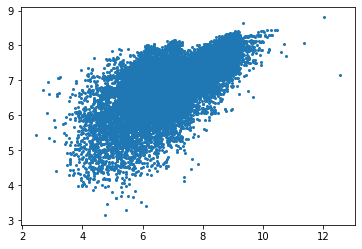

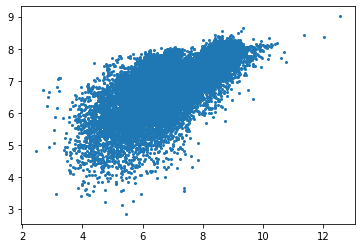

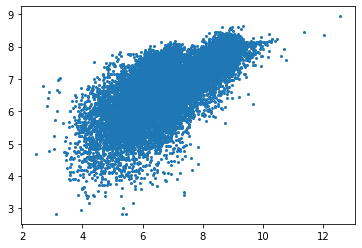

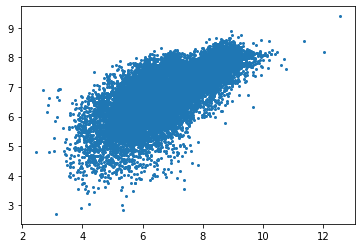

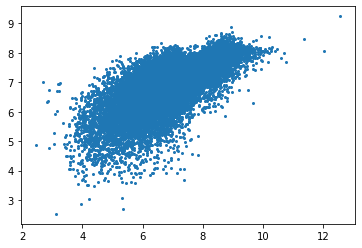

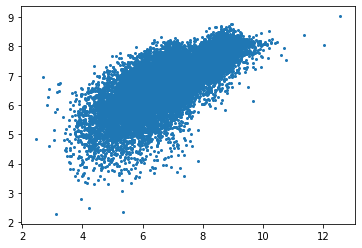

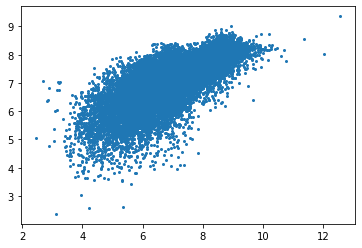

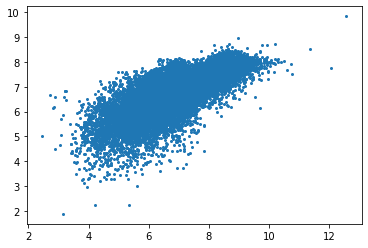

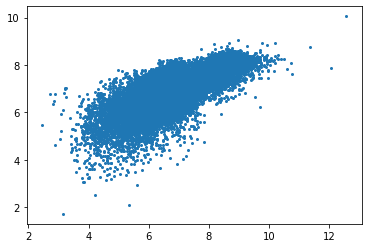

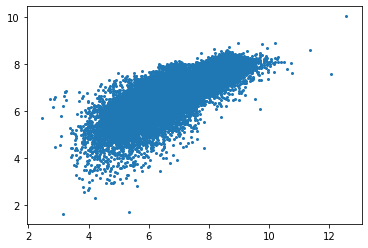

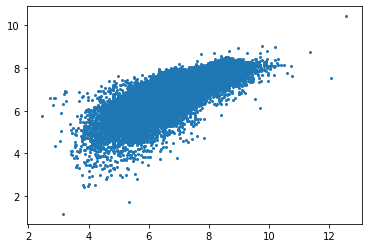

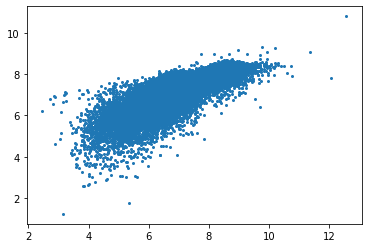

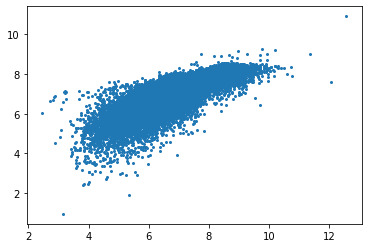

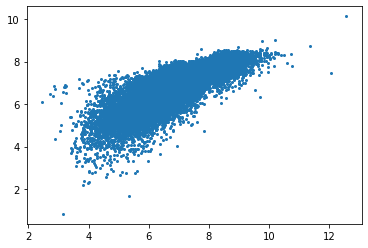

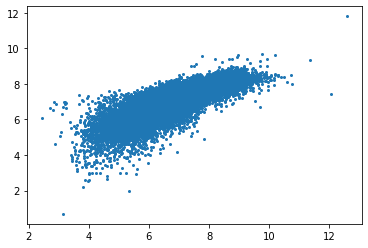

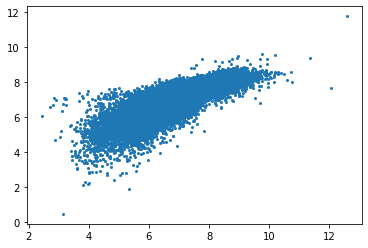

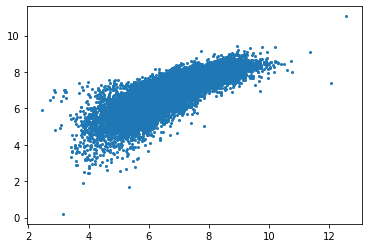

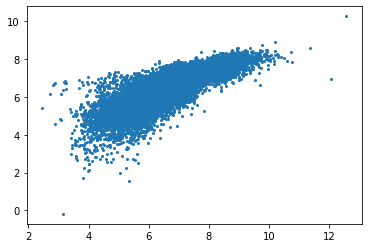

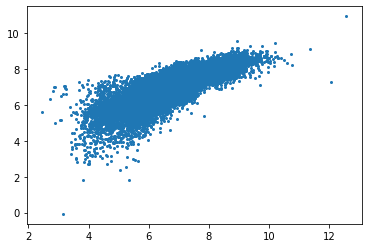

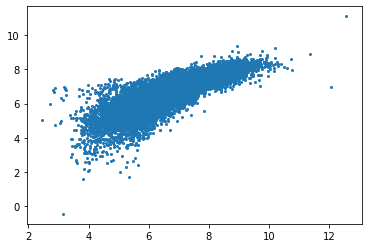

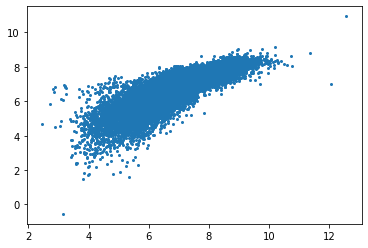

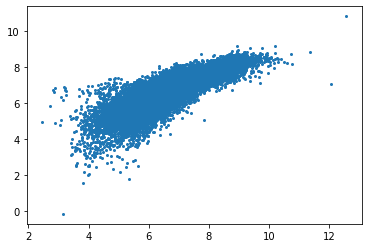

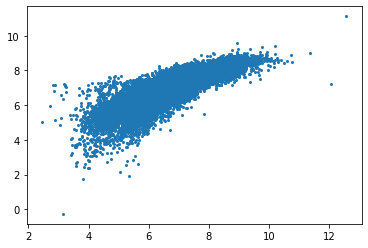

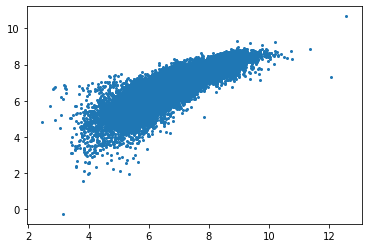

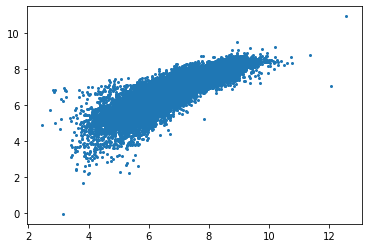

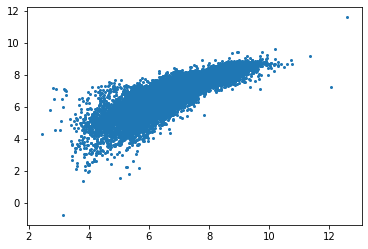

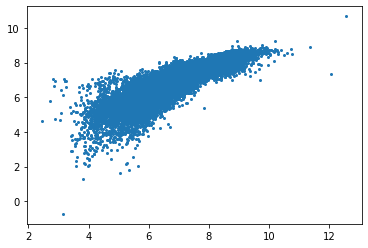

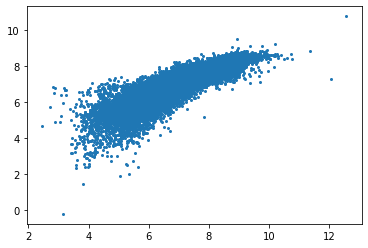

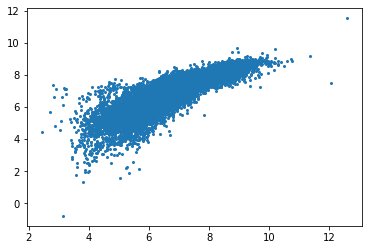

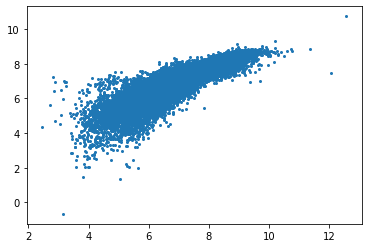

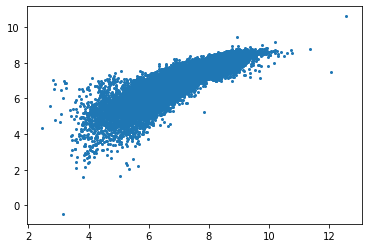

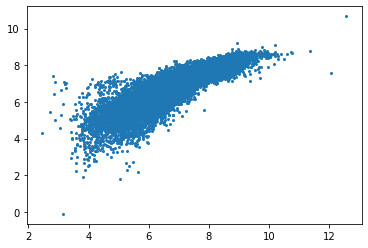

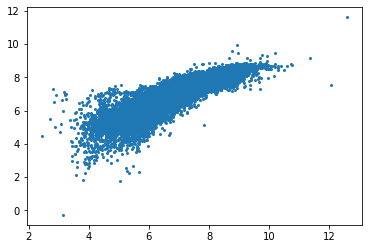

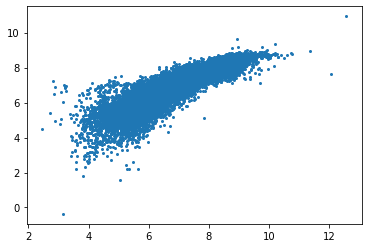

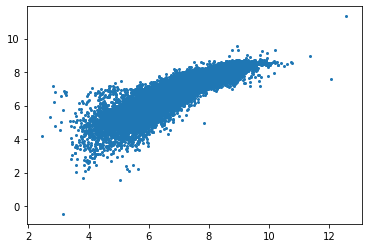

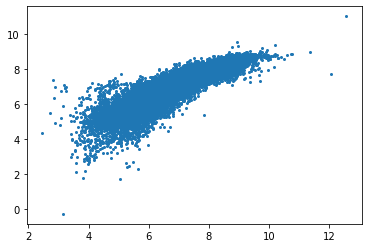

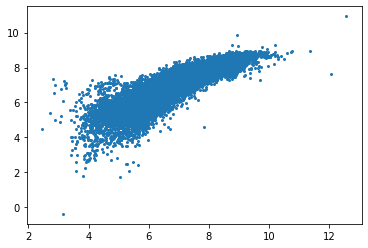

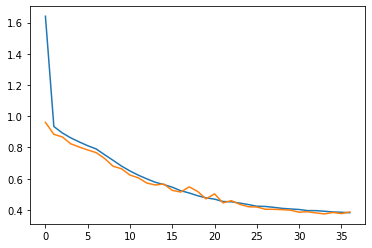

In [188]:
num_epochs = 50 #max number of epochs
train_losses = []
val_losses = []

best_val_loss = np.inf
patience_counter = 0
thresh = 0.005
patience = 3
for epoch in range(1, num_epochs + 1):
    train_loss = train(model, train_loader, criterion, optimizer)
    train_losses.append(train_loss)
    val_loss = evaluate(model, val_loader, criterion)
    val_losses.append(val_loss[0])

    fig,ax=plt.subplots()
    ax.plot(val_loss[1], val_loss[2], 'o', markersize = 2)

    print(f'Epoch {epoch} / {num_epochs}, Train loss: {train_loss:.4f}', f'Val loss: {val_loss[0]:.4f}')


    #early stopping

    if val_loss[0] < best_val_loss - thresh:
        best_val_loss = val_loss[0]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch}')
            break


fig,ax=plt.subplots()
ax.plot(train_losses, label='train loss')
ax.plot(val_losses, label='validation loss')

In [ ]:
val_loss = evaluate(model, val_loader)
test_loss = evaluate(model, test_loader)

print(f'Val Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}')

Test Loss: 0.3711
R2 score: 0.7724


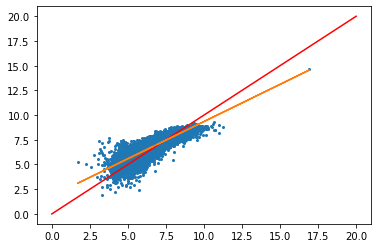

In [202]:
# test model

def test(model, loader):
    model.eval()
    total_loss = 0
    test_true = []
    test_pred = []
    with torch.no_grad():
        for data in loader:
            output = model(data)
            target = data.y[:,4]
            target = target.view(-1,1)
            loss = criterion(output, target)
            total_loss += loss.item()
            test_true.extend(np.array(target))
            test_pred.extend(np.array(output))
    return total_loss / len(loader), test_true, test_pred

test_loss = test(model, test_loader)
print(f'Test Loss: {test_loss[0]:.4f}')

fig,ax=plt.subplots()
ax.plot(test_loss[1], test_loss[2], 'o', markersize = 2)

x_vals = np.linspace(0,20,100)
ax.plot(x_vals,x_vals, color = 'red')

# regression line for test data without package
fit = np.polyval(np.polyfit(np.ravel(test_loss[1]), np.ravel(test_loss[2]), 1), np.ravel(test_loss[1]))
ax.plot(test_loss[1], fit)

#calculate r2 score
from sklearn.metrics import r2_score
r2 = r2_score(test_loss[1], test_loss[2])
print(f'R2 score: {r2:.4f}')


In [ ]:
#to do:
#tidy up graphs, axes, add r^2 for each validation epoch
#tinker / add documentation 